In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
import seaborn as sns
from tqdm.notebook import tqdm
%matplotlib inline

In [2]:
normalize_synergy = True
num_get_synergy_from = 15000

In [3]:
# Import the data and take a look
df = pd.read_csv('../Data/LOLOracleData.csv')
df.head()

,server,summoner_name,winner,BTop,BJng,BMid,BAdc,BSup,RTop,RJng,RMid,RAdc,RSup,Time
0,na,AnDa,Red,Camille,Gragas,Yone,Jhin,Brand,Shen,Graves,Sylas,Kai'Sa,Karma,2020-12-23 14:12:18 26m 18s
1,na,AnDa,Blue,Camille,Nidalee,Galio,Jhin,Anivia,Riven,Hecarim,Xerath,Miss Fortune,Vel'Koz,2020-12-23 13:19:48 20m 42s
2,na,AnDa,Blue,Irelia,Ekko,Annie,Kai'Sa,Thresh,Aatrox,Jarvan IV,Orianna,Aphelios,Maokai,2020-12-22 15:11:07 15m 20s
3,na,AnDa,Red,Graves,Kindred,Sylas,Vayne,Bard,Renekton,Nidalee,Ekko,Sivir,Pyke,2020-12-22 14:46:00 30m 34s
4,na,AnDa,Red,Camille,Lee Sin,Lucian,Kai'Sa,Leona,Jhin,Nidalee,Yone,Orianna,Pantheon,2020-12-22 13:59:22 29m 58s


In [4]:
# Drop irrelevant columns and rename winner
df.drop(['server','summoner_name','Time'],axis=1,inplace=True)
df.rename({'winner': 'Winner'}, axis=1, inplace=True)
df.head()

,Winner,BTop,BJng,BMid,BAdc,BSup,RTop,RJng,RMid,RAdc,RSup
0,Red,Camille,Gragas,Yone,Jhin,Brand,Shen,Graves,Sylas,Kai'Sa,Karma
1,Blue,Camille,Nidalee,Galio,Jhin,Anivia,Riven,Hecarim,Xerath,Miss Fortune,Vel'Koz
2,Blue,Irelia,Ekko,Annie,Kai'Sa,Thresh,Aatrox,Jarvan IV,Orianna,Aphelios,Maokai
3,Red,Graves,Kindred,Sylas,Vayne,Bard,Renekton,Nidalee,Ekko,Sivir,Pyke
4,Red,Camille,Lee Sin,Lucian,Kai'Sa,Leona,Jhin,Nidalee,Yone,Orianna,Pantheon


In [5]:
# Map winning team to numeric value
color_map = {'Blue': 0, 'Red': 1}
df['Winner'].replace(color_map, inplace=True)

In [6]:
# Define the roles, in general and per team. Collect all champions.
roles = ['Top', 'Jng', 'Mid', 'Adc', 'Sup']
blue_roles = [f"B{role}" for role in roles]
red_roles = [f"R{role}" for role in roles]
champions = np.unique(df[blue_roles+red_roles])
print(len(champions))

153


In [7]:
# We will not use the following, it is just a cool way to use numpy -> pandas, instead of the other way around.
# synergy = np.zeros((len(champions),)*2, dtype=int)
# synergy = pd.DataFrame(synergy, columns=champions, index=champions)

In [8]:
# Split the dataframe into blue and red, dropping the other team, respectively.
# Split further into winning and loosing of the corresponding team (This is faster 
#  than deciding for every row manually)
dfblue = df.iloc[:num_get_synergy_from].drop(red_roles, axis=1)
dfblue_wins = dfblue.loc[dfblue.Winner==0]
dfblue_loss = dfblue.loc[dfblue.Winner==1]

dfred = df.iloc[:num_get_synergy_from].drop(blue_roles, axis=1)
dfred_wins = dfred.loc[dfred.Winner==1]
dfred_loss = dfred.loc[dfred.Winner==0]

In [9]:
# Again, we use a python dictionary to collect the synergy score between all champions, for performance reasons.
synergy = {champ1 : {champ2: 0 for champ2 in champions} for champ1 in champions}
games_played = {champ1 : {champ2: 0 for champ2 in champions} for champ1 in champions}
factors = [1, -1, 1, -1]
sub_dfs = [dfblue_wins, dfblue_loss, dfred_wins, dfred_loss]
for factor, sub_df in zip(factors, sub_dfs):
    for i, line in tqdm(sub_df.iterrows()):
        linedata = line.iloc[1:].values
        for champ1, champ2 in itertools.combinations(linedata, 2):
            synergy[champ1][champ2] += factor
            games_played[champ1][champ2] += 1

print(f"Checksum (should be 0): {np.sum([np.sum(list(val.values())) for val in synergy.values()])}")

if normalize_synergy:
    for champ1, champ2 in itertools.product(champions, champions):
        if games_played[champ1][champ2]!=0:
            synergy[champ1][champ2] /= games_played[champ1][champ2]
            
# Here we then turn the dictionary into a dataframe, note that pandas understands the dict-of-dicts structure :)
df_synergy = pd.DataFrame(synergy)
# Because we use itertools.combination above, we need to symmetrize the score
df_synergy += df_synergy.transpose()
df_synergy /= 2

# As there are the same number of combinations in both teams, the summed synergy score always has to be 0.
df_synergy.head()

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Checksum (should be 0): 0


,Aatrox,Ahri,Akali,Alistar,Amumu,Anivia,Annie,Aphelios,Ashe,Aurelion Sol,...,Yasuo,Yone,Yorick,Yuumi,Zac,Zed,Ziggs,Zilean,Zoe,Zyra
Aatrox,0.000000,0.050000,0.021879,0.030973,0.000000,-0.425532,0.333333,-0.407407,-0.075342,0.214286,...,0.100000,0.306024,0.000000,0.016129,0.000000,-0.192982,0.000000,0.285714,0.152174,-0.227273
Ahri,0.050000,0.000000,-0.071429,-0.071429,-0.166667,-0.500000,-1.000000,-0.409091,-0.440000,0.000000,...,0.000000,-0.071429,0.000000,0.100000,-1.000000,0.500000,0.000000,0.166667,0.000000,-0.071429
Akali,0.021879,-0.071429,0.000000,-0.027473,-0.285714,0.018519,-0.533333,-0.060748,0.493333,0.500000,...,-0.129032,-0.182971,0.333333,0.014706,-0.256684,0.085271,0.500000,-0.042857,0.015152,0.115385
Alistar,0.030973,-0.071429,-0.027473,0.000000,0.187500,0.009804,0.083333,0.027273,0.046875,0.166667,...,-0.385542,-0.578231,-0.166667,0.000000,0.065217,-0.540000,0.055556,-0.250000,0.129630,0.000000
Amumu,0.000000,-0.166667,-0.285714,0.187500,0.000000,-0.214286,0.100000,-0.444444,-0.100000,-0.166667,...,0.066667,0.266667,-0.166667,-0.227273,0.500000,0.578947,0.500000,0.000000,-0.055556,-0.100000


In [56]:
# I think this was just a development cell.

# count=0
# i=0
# if i==0:
#     score = 0
#     bluechamps = list(df.loc[i,blue_roles].values)
#     for j in range(len(bluechamps)):
#             restchamps = bluechamps.copy()
#             restchamps.remove(bluechamps[j])
#             for k in range(len(restchamps)):
#                 print((int(synergy.loc[bluechamps[j],[restchamps[k]]].values)))
#                 count+=1
#     print(f'\n\ncount is: {count}')


In [10]:
# Synergy scores per team. Again using python data structures for performance to not access df very often.

BSyn = []
RSyn = []
for i, row in tqdm(df.iterrows()):
    for team, roles, Syn in zip(['B', 'R'], [blue_roles, red_roles], [BSyn, RSyn]):
        score = 0
        for champ1, champ2 in itertools.combinations(row[roles], 2):
            score += synergy[champ1][champ2]
        Syn.append(score)

df['BSyn'] = BSyn
df['RSyn'] = RSyn

0it [00:00, ?it/s]

In [11]:
df['SynPredictsWin'] = df.apply(lambda x: x.Winner==(x.RSyn>x.BSyn), axis=1)
train_correct = np.sum(df.loc[:num_get_synergy_from, 'SynPredictsWin'])
train_perc = train_correct/num_get_synergy_from*100
test_correct = np.sum(df.loc[num_get_synergy_from:, 'SynPredictsWin'])
test_perc = test_correct/(len(df)-num_get_synergy_from)*100
correct = train_correct + test_correct

print(f"Predicting the winner from the team's synergy score:")
print(f"'Training' data: {train_correct:5d} out of {num_get_synergy_from:5d} ({train_perc:.1f}%)")
print(f"'Test' data:     {test_correct:5d} out of {len(df)-num_get_synergy_from:5d} ({test_perc:.1f}%)")
print(f"Total data:      {correct} out of {len(df)} ({correct/len(df)*100:.1f}%)")


Predicting the winner from the team's synergy score:
'Training' data: 12222 out of 15000 (81.5%)
'Test' data:      2503 out of  4679 (53.5%)
Total data:      14725 out of 19679 (74.8%)


In [17]:
df.head()

,Winner,BTop,BJng,BMid,BAdc,BSup,RTop,RJng,RMid,RAdc,RSup,BSyn,RSyn,SynPredictsWin
0,1,Camille,Gragas,Yone,Jhin,Brand,Shen,Graves,Sylas,Kai'Sa,Karma,-0.377362,0.340565,True
1,0,Camille,Nidalee,Galio,Jhin,Anivia,Riven,Hecarim,Xerath,Miss Fortune,Vel'Koz,1.457897,0.420130,True
2,0,Irelia,Ekko,Annie,Kai'Sa,Thresh,Aatrox,Jarvan IV,Orianna,Aphelios,Maokai,0.521462,-0.716379,True
3,1,Graves,Kindred,Sylas,Vayne,Bard,Renekton,Nidalee,Ekko,Sivir,Pyke,-0.282721,0.435248,True
4,1,Camille,Lee Sin,Lucian,Kai'Sa,Leona,Jhin,Nidalee,Yone,Orianna,Pantheon,-0.037606,0.600661,True


In [18]:
df_synergy.reset_index()

,index,Aatrox,Ahri,Akali,Alistar,Amumu,Anivia,Annie,Aphelios,Ashe,...,Yasuo,Yone,Yorick,Yuumi,Zac,Zed,Ziggs,Zilean,Zoe,Zyra
0,Aatrox,0.000000,-0.021739,0.036574,0.040000,0.000000,-0.397059,0.352941,-0.422222,-0.100000,...,0.004167,-0.018519,0.000000,0.014286,-0.088235,-0.050000,0.055556,0.285714,0.521739,-0.227273
1,Ahri,-0.021739,0.000000,-0.500000,0.000000,-0.166667,0.000000,-1.000000,-0.428571,-0.533333,...,0.000000,-0.071429,0.500000,0.050000,-1.000000,0.500000,0.000000,0.166667,0.000000,-0.071429
2,Akali,0.036574,-0.500000,0.000000,0.004702,-0.077295,-0.461538,-0.529412,0.105556,0.484694,...,-0.062865,-0.179648,0.333333,0.012500,-0.352381,0.161094,0.500000,0.472222,0.229167,0.071429
3,Alistar,0.040000,0.000000,0.004702,0.000000,0.131579,0.015152,0.055556,0.057895,0.039474,...,-0.380597,-0.538117,-0.166667,0.000000,0.089744,-0.491525,0.000000,-0.250000,0.063291,0.000000
4,Amumu,0.000000,-0.166667,-0.077295,0.131579,0.000000,-0.214286,0.214286,-0.333333,-0.100000,...,-0.047619,0.254902,-0.166667,-0.227273,0.500000,0.578947,0.500000,0.000000,0.000000,-0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,Zed,-0.050000,0.500000,0.161094,-0.491525,0.578947,0.500000,0.666667,-0.560000,-0.457627,...,0.214286,0.314286,-0.571429,-0.558140,-0.071429,0.000000,0.444444,-0.055556,0.000000,0.300000
149,Ziggs,0.055556,0.000000,0.500000,0.000000,0.500000,-0.500000,0.000000,-0.500000,-0.400000,...,-0.200000,0.416667,0.500000,-0.100000,1.000000,0.444444,0.000000,0.000000,0.166667,0.500000
150,Zilean,0.285714,0.166667,0.472222,-0.250000,0.000000,-0.200000,0.500000,-0.100000,0.186207,...,-0.785714,-0.542857,0.500000,-0.500000,0.071429,-0.055556,0.000000,0.000000,0.000000,0.000000
151,Zoe,0.521739,0.000000,0.229167,0.063291,0.000000,0.000000,0.750000,-0.506667,0.483871,...,0.571429,-0.500000,0.500000,-0.083333,-0.052174,0.000000,0.166667,0.000000,0.000000,0.000000


<IPython.core.display.Javascript object>


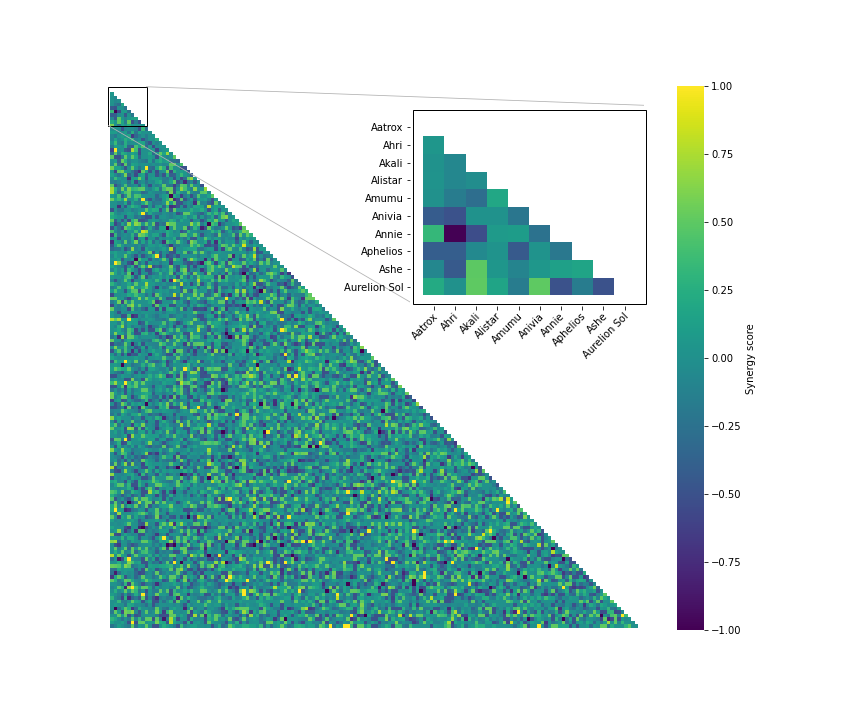

In [70]:
%matplotlib notebook
num_subplot = 10
# Create axes
gridspec_kw = {'height_ratios': [2,4]}
fig, axs = plt.subplots(1, 1, figsize=(12,10))#, gridspec_kw=gridspec_kw)
if not hasattr(axs, '__getitem__'):
    axs = [None, axs]
subax = fig.add_axes([0.475, 0.575, 0.275, 0.275])

plot_synergy = df_synergy.to_numpy()
mask = np.ones_like(plot_synergy, dtype=bool)
mask_indices = np.tril_indices_from(mask, -1)
mask[mask_indices] = False
masked_synergy = plot_synergy[~mask]

subdf_synergy = df_synergy.iloc[:num_subplot, :num_subplot]
subplot_synergy = plot_synergy[:num_subplot, :num_subplot]
submask = np.ones_like(subplot_synergy, dtype=bool)
submask_indices = np.tril_indices_from(submask, -1)
submask[submask_indices] = False
submasked_synergy = subplot_synergy[submask_indices]

# sns.histplot(
#     masked_synergy,
#     ax=axs[0],
# )

sns.heatmap(
    ax=axs[1],
    data=plot_synergy,
    cmap=mpl.cm.viridis,
    mask=mask,
#     square=True,
    xticklabels=[],
    yticklabels=[],
)

sns.heatmap(
    ax=subax,
    data=subdf_synergy,
    cmap=mpl.cm.viridis,
    mask=submask,
    vmin=-1,
    vmax=1,
    cbar=False,
#     square=True,
)

frames = [mpl.patches.Rectangle(
    (-0.5, -0.5),
    num_subplot+1,
    num_subplot+1,
    linewidth=1,
    edgecolor='k',
    facecolor='none'
) for _ in range(2)]

for i, ax in enumerate([axs[1], subax]):
    ax.add_patch(frames[i])
    xlim = ax.get_xlim()
    ax.set_xlim((xlim[0]-0.6, xlim[1]+0.6))
    ylim = ax.get_ylim()
    ax.set_ylim((ylim[0]+0.6, ylim[1]-0.6))

fig_width = fig.get_window_extent().width
fig_height = fig.get_window_extent().height
lower_left = axs[1].transData.inverted().transform((0.475*fig_width, 0.575*fig_height))
upper_right = axs[1].transData.inverted().transform((0.775*fig_width, 0.85*fig_height))

c = '0.7'
axs[1].plot([-0.5, lower_left[0]+1], [num_subplot+0.5, lower_left[1]-0.5], color=c, linewidth=0.8, zorder=101)
axs[1].plot([num_subplot+0.5, upper_right[0]], [-0.5, upper_right[1]-0.5], color=c, linewidth=0.8, zorder=101)

plt.setp(subax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# apply offset transform to all x ticklabels.
offset = mpl.transforms.ScaledTranslation(6/72, 2/72, fig.dpi_scale_trans)
for label in subax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
    
cbar = axs[1].collections[0].colorbar
cbar.set_label('Synergy score')
plt.savefig('../Plots/synergy_heatmap.png')

<IPython.core.display.Javascript object>


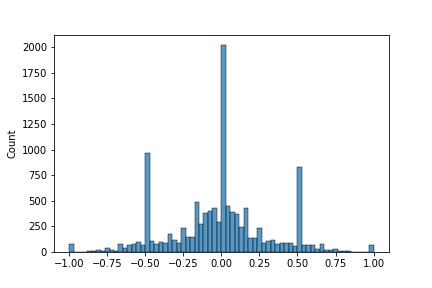

array([ 0.05      ,  0.02187902, -0.07142857, ...,  0.5       ,
        0.        ,  0.        ])

In [74]:
%matplotlib notebook
sns.histplot(masked_synergy)
masked_synergy

In [27]:

synergy.to_csv('Synergyscores.csv',index=False)

AttributeError: 'dict' object has no attribute 'to_csv'

In [ ]:
df.to_csv('LOLOracleDatawithSynscores.csv',index=False)

In [ ]:
a = axs[1]
a.get_window_extent().height

In [ ]:
np.min(np.min(df_synergy))